# Predict Sales

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import gc  # For garbage collection to free up memory
import tqdm
from tqdm import tqdm_notebook
from datetime import datetime
from itertools import product  # Cartesian product, equivalent to a nested for-loop
import matplotlib.pyplot as plt

import sklearn
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor  # Scikit-Learn wrapper around XGBoost
from xgboost import plot_importance  # Will enable us to see the feature importance
from catboost import CatBoostRegressor

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

for p in [np, pd, sklearn, lgb, xgb, cb, tqdm]:
    print (p.__name__, p.__version__)
    
# Define function to turn all 64-bit variables in a dataframe into 32-bit variables to save memory
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

numpy 1.14.0
pandas 0.22.0+0.ga00154d.dirty
sklearn 0.19.1
lightgbm 2.1.0
xgboost 0.7
catboost 0.6.1.1
tqdm 4.19.4


# Read in the Data

In [2]:
# Read in the sales data
df_sales_train = pd.read_csv('./data/sales_train_v2.csv')
df_items = pd.read_csv('./data/items.csv')  # We want the item categories too...

# Drop the date and item_name columns
sales = df_sales_train.drop(['date'], axis=1)

# Read in the actual unlabeled test data
df_test = pd.read_csv('./data/test.csv')

print(sales.head())

   date_block_num  shop_id  item_id  item_price  item_cnt_day
0               0       59    22154      999.00           1.0
1               0       25     2552      899.00           1.0
2               0       25     2552      899.00          -1.0
3               0       25     2554     1709.05           1.0
4               0       25     2555     1099.00           1.0


# For a look at the data, see PredictSalesEDA.ipynb

# First we will work with combined shop_id / item_id

In [3]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in tqdm_notebook(sales['date_block_num'].unique()):
    shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[shops, items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

print(grid.head())
print(grid.shape)

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.



   shop_id  item_id  date_block_num
0       59    22154               0
1       59     2552               0
2       59     2554               0
3       59     2555               0
4       59     2564               0
(10913850, 3)


In [4]:
# Append the month 34 shops and items (the test month without any of the training features)
test_month = df_test.drop(['ID'], axis=1)
test_month['date_block_num'] = 34

grid = grid.append(test_month)

grid.tail()

,shop_id,item_id,date_block_num
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34
214198,45,19648,34
214199,45,969,34


# Next do some feature engineering

In [5]:
# Drop the outliers in the sales data (see the initial EDA above).
sales = sales[sales.item_price<50000]
sales = sales[sales.item_cnt_day<=600]

In [6]:
# Fill out our grid with the item price, counts, and categories
sales = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales = pd.merge(grid,sales,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)

print(sales.head())
print(sales.shape)

   shop_id  item_id  date_block_num  item_cnt_day  item_price
0       59    22154               0           1.0       999.0
1       59     2552               0           0.0         0.0
2       59     2554               0           0.0         0.0
3       59     2555               0           0.0         0.0
4       59     2564               0           0.0         0.0
(11128050, 5)


In [7]:
# Join sales dataframe to df_items to get the categories
sales = pd.merge(sales, df_items, how='left', on=['item_id'])
sales = sales.drop(['item_name'], axis=1)  # We don't need the item name

print(sales.head())
print(sales.shape)

   shop_id  item_id  date_block_num  item_cnt_day  item_price  \
0       59    22154               0           1.0       999.0   
1       59     2552               0           0.0         0.0   
2       59     2554               0           0.0         0.0   
3       59     2555               0           0.0         0.0   
4       59     2564               0           0.0         0.0   

   item_category_id  
0                37  
1                58  
2                58  
3                56  
4                59  
(11128050, 6)


In [8]:
# Create mean encodings as taught in the class (week 3).  We will create the following aggregates for item_id, 
# shop_id and item_category_id:  mean item price, daily sum of item counts, and daily mean of item counts.
for type_id in tqdm_notebook(['item_id','shop_id','item_category_id']):
    for column, agg, aggtype in [('item_price',np.mean,'mean'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'mean')]:
        new_col = sales.groupby([type_id,'date_block_num']).aggregate(agg).reset_index()[[column,type_id,'date_block_num']]
        new_col.columns = [type_id+'_'+aggtype+'_'+column,type_id,'date_block_num']
        
        sales = pd.merge(sales, new_col, on=['date_block_num',type_id],how='left')
        
print(sales.tail())
print(sales.shape)

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.



          shop_id  item_id  date_block_num  item_cnt_day  item_price  \
11128045       45    18454              34           0.0         0.0   
11128046       45    16188              34           0.0         0.0   
11128047       45    15757              34           0.0         0.0   
11128048       45    19648              34           0.0         0.0   
11128049       45      969              34           0.0         0.0   

          item_category_id  item_id_mean_item_price  item_id_sum_item_cnt_day  \
11128045                55                      0.0                       0.0   
11128046                64                      0.0                       0.0   
11128047                55                      0.0                       0.0   
11128048                40                      0.0                       0.0   
11128049                37                      0.0                       0.0   

          item_id_mean_item_cnt_day  shop_id_mean_item_price  \
11128045       

In [9]:
# Free up some memory
sales = downcast_dtypes(sales)  # We don't need 64-bit variables for this problem, so downcast them to 32-bits
del grid
gc.collect()

428

In [10]:
# Clip the item_cnt_day to a range of 0 to 45 (0 to 20 is the clipping range for this contest but that would
# not give us enough tree nodes if 20 really was an answer)
def clip(x):
    if x>45:  # raising to 45 improved the leaderboard score from 0.95476 to 0.95281
        return 45
    elif x<0:
        return 0
    else:
        return x

sales['item_cnt_day'] = sales.apply(lambda x: clip(x['item_cnt_day']),axis=1)

In [11]:
# Create lag variables
lag_variables = list(sales.columns[6:])+['item_cnt_day']
lags = [1, 2, 3, 4, 5, 12]  # Number of months to lag

for lag in tqdm_notebook(lags):
    sales_lag = sales.copy()
    sales_lag.date_block_num+=lag
    sales_lag = sales_lag[['date_block_num','shop_id','item_id']+lag_variables]
    sales_lag.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    sales = pd.merge(sales, sales_lag, on=['date_block_num','shop_id','item_id'], how='left')
print(sales.shape)

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.



(11128050, 75)


In [12]:
# Don't use old data from year 2013
sales = sales[sales['date_block_num'] >= 12] 

# We will drop these at fitting stage (since the real test data - month 34 - doesn't have these)
cols_to_drop = lag_variables[:-1] + ['item_cnt_day'] + ['item_price']

# Fill NaNs with zeros for counts and the median for prices
for feature in tqdm_notebook(sales.columns):
    if 'item_cnt' in feature:
        sales[feature]=sales[feature].fillna(0)
    elif 'item_price' in feature:
        sales[feature]=sales[feature].fillna(sales[feature].median())

print(cols_to_drop)
print(sales.shape)

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.



['item_id_mean_item_price', 'item_id_sum_item_cnt_day', 'item_id_mean_item_cnt_day', 'shop_id_mean_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_mean_item_cnt_day', 'item_category_id_mean_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_mean_item_cnt_day', 'item_cnt_day', 'item_price']
(6639294, 75)


# Prep for training

In [13]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = sales['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 34


In [14]:
dates_train = dates[dates <  (last_block)]  # Remember the last block is now block 34 (the real test data)
dates_test  = dates[dates == (last_block)]

X_train = sales.loc[dates <  (last_block)].drop(cols_to_drop, axis=1)
X_test =  sales.loc[dates == (last_block)].drop(cols_to_drop, axis=1)
print(X_train.shape)
print(X_test.shape)

y_train = sales.loc[dates <  (last_block), 'item_cnt_day'].values
y_test =  sales.loc[dates == (last_block), 'item_cnt_day'].values  # y_test is what we need to predict for the contest
print("y_train head: ", y_train)
print("y_test head: ", y_test)

(6425094, 64)
(214200, 64)
y_train head:  [ 4.  3. 14. ...  0.  0.  0.]
y_test head:  [0. 0. 0. ... 0. 0. 0.]


# First level models
We will use scheme f from the class since we have a time component.  We use first level models to build two datasets: test meta-features and 2nd level train-metafeatures.

## Test meta-features
First run the models on the numeric columns and get predictions for the validation month

In [15]:
# Linear regression first
pipe_lr = Pipeline([('scl', StandardScaler()),  \
                    ('lr', LinearRegression(n_jobs=16))]) # Create a pipeline w/ scaling

print("Running Linear Regression")
start = datetime.now()

pipe_lr.fit(X_train.values, y_train)
pred_lr = pipe_lr.predict(X_test.values)

stop = datetime.now()

print("Linear regression ellapsed time = ", stop - start)

# Then LightGBM
lgb_params = {   # Parameters selected via grid search in another notebook
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.05,  # See the grid search notebook for more details
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'n_estimators': 75,  # See the grid search notebook for more details
               'verbose':0,
               'device': 'gpu',
               'max_bin': 63  # Recommended to enhance GPU performance
              }

print("Running LightGBM")
start = datetime.now()

lgbmodel = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = lgbmodel.predict(X_test)

stop = datetime.now()

print("LightGBM ellapsed time = ", stop - start)

# Then XGBoost
xgbmodel = XGBRegressor(max_depth=8,  # See the grid search notebook for more details
               learning_rate=0.05,  # See the grid search notebook for more details
               n_estimators=85, # Number of boosted trees to fit - See the grid search notebook for more details
               objective='reg:linear',  # RMSE is the default metric for regression in XGBoost
               gamma=0, # Minimum loss reduction required to make a further partition on a leaf node of the tree
               min_child_weight=1, # Minimum sum of instance weight(hessian) needed in a child
               subsample=0.8, # Subsample ratio of the training instance
               colsample_bytree=0.8, # Subsample ratio of columns when constructing each tree 
               colsample_bylevel=0.8, # Subsample ratio of columns for each split, in each level
               reg_alpha=0, # L1 regularization weights
               reg_lambda=1, # L2 regularization weights
               scale_pos_weight=1, # Balancing of positive and negative weights
               random_state=0,  # Random seed
               gpu_id=0,  # From nvidia-smi this is the gtx 1080ti
               max_bin=32, # For the GPU histogram method
               tree_method='gpu_hist' # XGBoost fast histogram (other option is gpu_exact)
            )

print("Running XGBoost")
start = datetime.now()

xgbmodel.fit(X_train.values, y_train)
pred_xgb = xgbmodel.predict(X_test.values)

stop = datetime.now()

print("XGBoost ellapsed time = ", stop - start)

# Finally Catboost
cbmodel = CatBoostRegressor(learning_rate = 0.01, depth=1, iterations=50, loss_function='RMSE', \
                            device_config='GPU', task_type = 'GPU')  # See the grid search notebook for more details

print("Running Catboost")
start = datetime.now()
cbmodel.fit(X_train.values, y_train)

pred_cb = cbmodel.predict(X_test.values)
stop = datetime.now()

print("Catboost ellapsed time = ", stop - start)

# Concatenate test predictions to get test meta-features
X_test_level2 = np.c_[pred_lr, pred_lgb, pred_xgb, pred_cb]

Running Linear Regression
Linear regression ellapsed time =  0:03:25.314018
Running LightGBM


/home/christina/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LightGBM ellapsed time =  0:12:06.471544
Running XGBoost
XGBoost ellapsed time =  0:04:34.265212
Running Catboost
0:	learn: 1.509580393	total: 78.8ms	remaining: 3.86s
1:	learn: 1.506299856	total: 114ms
	remaining: 2.74s2:	learn: 1.503082986	total: 143ms	remaining: 2.24s
3:	learn: 1.499921789	total: 172ms
	remaining: 1.98s4:	learn: 1.49679608	total: 202ms
	remaining: 1.82s5:	learn: 1.493727444	total: 231ms	remaining: 1.69s
6:	learn: 1.490693366	total: 262ms
	remaining: 1.61s7:	learn: 1.487712471	total: 292ms
	remaining: 1.53s8:	learn: 1.484777218	total: 322ms
	remaining: 1.47s9:	learn: 1.481901375	total: 351ms	remaining: 1.4s
10:	learn: 1.47903262	total: 378ms
	remaining: 1.34s11:	learn: 1.476208634	total: 405ms	remaining: 1.28s
12:	learn: 1.473427985	total: 432ms	remaining: 1.23s
13:	learn: 1.470687109	total: 460ms	remaining: 1.18s
14:	learn: 1.467994446	total: 488ms	remaining: 1.14s
15:	learn: 1.465330186	total: 515ms	remaining: 1.09s
16:	learn: 1.462686824	total: 543ms
	remaining: 1.

## Train meta-features
Implementing scheme f, get predictions (meta-features) from linear regression, LightGBM, XGBoost and Catboost for months 27, 28, 29, 30, 31, 32

In [16]:
training_months = [27, 28, 29, 30, 31, 32, 33]
dates_train_level2 = dates_train[dates_train.isin(training_months)]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(training_months)]

In [17]:
# Create 2nd level feature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 4])

# Fill `X_train_level2` with metafeatures
for cur_block_num in tqdm_notebook(training_months):
      
    print("Current block number = ", cur_block_num)
    
    #  Split X_train into parts
    X_train_block = X_train[dates_train <  cur_block_num]
    X_test_block =  X_train[dates_train == cur_block_num]

    y_train_block = y_train[dates_train < cur_block_num] 
    y_test_block =  y_train[dates_train == cur_block_num] 
    
    # Fit linear regression
    pipe_lr2 = Pipeline([('scl', StandardScaler()),  \
                    ('lr', LinearRegression(n_jobs=16))]) # Create a pipeline w/ scaling

    start = datetime.now()

    pipe_lr2.fit(X_train_block.values, y_train_block)
    pred_lr = pipe_lr.predict(X_test_block.values)

    stop = datetime.now()

    print("Ellapsed time = ", stop - start)
    print("Test R-squared for linreg is %f" % r2_score(y_test_block, pred_lr))
    print("Test RMSE for linreg is ", sqrt(mean_squared_error(y_test_block, pred_lr)))
    
    # Fit LightGBM
    ds = lgb.Dataset(X_train_block.values, label=y_train_block)
    start = datetime.now()

    model = lgb.train(lgb_params, ds, 100)
    pred_lgb = model.predict(X_test_block.values)
    stop = datetime.now()

    print("Ellapsed time = ", stop - start)
    print("Test R-squared for LightGBM is %f" % r2_score(y_test_block, pred_lgb))
    print("Test RMSE for LightGBM is ", sqrt(mean_squared_error(y_test_block, pred_lgb)))
    
    # Fit XGBoost
    xgbmodel = XGBRegressor(max_depth=8, 
               learning_rate=0.05, 
               n_estimators=85, # Number of boosted trees to fit - see the grid search notebook
               objective='reg:linear',  # RMSE is the default metric for regression in XGBoost
               gamma=0, # Minimum loss reduction required to make a further partition on a leaf node of the tree
               min_child_weight=1, # Minimum sum of instance weight(hessian) needed in a child
               subsample=0.8, # Subsample ratio of the training instance
               colsample_bytree=0.8, # Subsample ratio of columns when constructing each tree 
               colsample_bylevel=0.8, # Subsample ratio of columns for each split, in each level
               reg_alpha=0, # L1 regularization weights
               reg_lambda=1, # L2 regularization weights
               scale_pos_weight=1, # Balancing of positive and negative weights
               random_state=0,  # Random seed
               gpu_id=0,  # From nvidia-smi this is the gtx 1080ti
               max_bin=32, # For the GPU histogram method
               tree_method='gpu_hist' # XGBoost fast histogram (other option is gpu_exact)
            )

    start = datetime.now()

    xgbmodel.fit(X_train_block.values, y_train_block)
    pred_xgb = xgbmodel.predict(X_test_block.values)

    stop = datetime.now()

    print("Month = ", cur_block_num, " Ellapsed time = ", stop - start)
    print("Test R-squared for XGBoost is %f" % r2_score(y_test_block, pred_xgb))
    print("Test RMSE for XGBoost is ", sqrt(mean_squared_error(y_test_block, pred_xgb)))
    
    # Fit Catboost
    cbmodel = CatBoostRegressor(learning_rate=0.01, iterations=50, depth=1, loss_function='RMSE', device_config='GPU', \
                           task_type = 'GPU')
#    cbmodel = CatBoostRegressor(loss_function='RMSE', device_config='GPU', task_type = 'GPU')

    start = datetime.now()
    cbmodel.fit(X_train_block.values, y_train_block)

    pred_cb = cbmodel.predict(X_test_block.values)
    stop = datetime.now()

    print("Ellapsed time = ", stop - start)
    print('Test R-squared for Catboost is %f' % r2_score(y_test_block, pred_cb))
    print("Test RMSE for Catboost is ", sqrt(mean_squared_error(y_test_block, pred_cb)))
    
    # Store predictions
    X_train_level2[dates_train_level2==cur_block_num] = np.c_[pred_lr, pred_lgb, pred_xgb, pred_cb] # Concat into X_train_level2
    
print("X_train_level2 = ", X_train_level2)

The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Current block number =  27
Ellapsed time =  0:02:21.144350
Test R-squared for linreg is 0.276350
Test RMSE for linreg is  1.266820985608071
Ellapsed time =  0:10:54.927963
Test R-squared for LightGBM is 0.325282
Test RMSE for LightGBM is  1.2232411005193868
Month =  27  Ellapsed time =  0:03:28.263242
Test R-squared for XGBoost is 0.310809
Test RMSE for XGBoost is  1.2362914450527547
0:	learn: 1.539438499	total: 73.5ms	remaining: 3.6s
1:	learn: 1.535968938	total: 109ms	remaining: 2.62s
2:	learn: 1.532574939	total: 132ms
	remaining: 2.07s3:	learn: 1.529209157	total: 153ms
	remaining: 1.76s4:	learn: 1.525918165	total: 177ms	remaining: 1.59s
5:	learn: 1.522659651	total: 199ms	remaining: 1.46s
6:	learn: 1.519451265	total: 221ms	remaining: 1.35s
7:	learn: 1.516306487	total: 242ms	remaining: 1.27s
8:	learn: 1.513174955	total: 279ms
	remaining: 1.27s9:	learn: 1.510105619	total: 303ms	remaining: 1.21s
10:	learn: 1.507094927	total: 326ms
	remaining: 1.16s11:	learn: 1.504098594	total: 348ms	rema

30:	learn: 1.454436938	total: 959ms	remaining: 588ms
31:	learn: 1.452195455	total: 983ms	remaining: 553ms
32:	learn: 1.449960525	total: 1.01s	remaining: 519ms
33:	learn: 1.447764562	total: 1.03s	remaining: 486ms
34:	learn: 1.4456005	total: 1.07s	remaining: 459ms
35:	learn: 1.443462275	total: 1.09s	remaining: 426ms
36:	learn: 1.441341427	total: 1.12s	remaining: 394ms
37:	learn: 1.439226827	total: 1.15s
	remaining: 362ms38:	learn: 1.437167664	total: 1.17s	remaining: 331ms
39:	learn: 1.435108964	total: 1.2s	remaining: 300ms
40:	learn: 1.433078376	total: 1.22s	remaining: 268ms
41:	learn: 1.431085114	total: 1.25s	remaining: 238ms
42:	learn: 1.429095938	total: 1.27s	remaining: 207ms
43:	learn: 1.42713902	total: 1.3s	remaining: 177ms
44:	learn: 1.425214164	total: 1.32s	remaining: 147ms
45:	learn: 1.423287169	total: 1.34s	remaining: 117ms
46:	learn: 1.42138132	total: 1.37s	remaining: 87.3ms
47:	learn: 1.41950069	total: 1.41s	remaining: 58.6ms
48:	learn: 1.417638059	total: 1.43s	remaining: 29.2

	remaining: 1.47s8:	learn: 1.484272711	total: 306ms	remaining: 1.39s
9:	learn: 1.481321773	total: 332ms	remaining: 1.33s
10:	learn: 1.478426316	total: 358ms	remaining: 1.27s
11:	learn: 1.475568497	total: 385ms	remaining: 1.22s
12:	learn: 1.472755874	total: 411ms
	remaining: 1.17s13:	learn: 1.469964086	total: 438ms	remaining: 1.13s
14:	learn: 1.467223743	total: 465ms	remaining: 1.08s
15:	learn: 1.46450676	total: 491ms	remaining: 1.04s
16:	learn: 1.461836478	total: 518ms	remaining: 1s
17:	learn: 1.459189615	total: 545ms	remaining: 968ms
18:	learn: 1.45658683	total: 571ms
	remaining: 932ms19:	learn: 1.454026576	total: 606ms
	remaining: 909ms20:	learn: 1.45147381	total: 632ms	remaining: 873ms
21:	learn: 1.448960143	total: 659ms	remaining: 839ms
22:	learn: 1.446473904	total: 686ms	remaining: 806ms
23:	learn: 1.444021734	total: 714ms	remaining: 773ms
24:	learn: 1.441588522	total: 744ms
	remaining: 744ms25:	learn: 1.439189558	total: 771ms
	remaining: 712ms26:	learn: 1.436821514	total: 798ms
	

### Get the feature importances

In [18]:
feature_names = list(X_train_block)  # The list of features
feature_names

['shop_id',
 'item_id',
 'date_block_num',
 'item_category_id',
 'item_id_mean_item_price_lag_1',
 'item_id_sum_item_cnt_day_lag_1',
 'item_id_mean_item_cnt_day_lag_1',
 'shop_id_mean_item_price_lag_1',
 'shop_id_sum_item_cnt_day_lag_1',
 'shop_id_mean_item_cnt_day_lag_1',
 'item_category_id_mean_item_price_lag_1',
 'item_category_id_sum_item_cnt_day_lag_1',
 'item_category_id_mean_item_cnt_day_lag_1',
 'item_cnt_day_lag_1',
 'item_id_mean_item_price_lag_2',
 'item_id_sum_item_cnt_day_lag_2',
 'item_id_mean_item_cnt_day_lag_2',
 'shop_id_mean_item_price_lag_2',
 'shop_id_sum_item_cnt_day_lag_2',
 'shop_id_mean_item_cnt_day_lag_2',
 'item_category_id_mean_item_price_lag_2',
 'item_category_id_sum_item_cnt_day_lag_2',
 'item_category_id_mean_item_cnt_day_lag_2',
 'item_cnt_day_lag_2',
 'item_id_mean_item_price_lag_3',
 'item_id_sum_item_cnt_day_lag_3',
 'item_id_mean_item_cnt_day_lag_3',
 'shop_id_mean_item_price_lag_3',
 'shop_id_sum_item_cnt_day_lag_3',
 'shop_id_mean_item_cnt_day_lag_

In [19]:
# Feature importances for LightGBM
lgb_importances = pd.DataFrame(model.feature_importance(), columns=['Importance'])
lgb_importances['Feature Name'] = feature_names
lgb_importances.sort_values(by=['Importance'], inplace=True)
lgb_importances = lgb_importances[['Feature Name', 'Importance']].set_index('Feature Name')
lgb_importances.head(20)

,Importance
Feature Name,
item_id_mean_item_price_lag_12,18
item_id_mean_item_cnt_day_lag_12,20
shop_id_mean_item_price_lag_12,22
item_id_mean_item_cnt_day_lag_5,30
shop_id_mean_item_price_lag_4,35
shop_id_sum_item_cnt_day_lag_4,38
shop_id_mean_item_cnt_day_lag_4,38
item_id_mean_item_cnt_day_lag_3,45
item_id_mean_item_cnt_day_lag_4,46


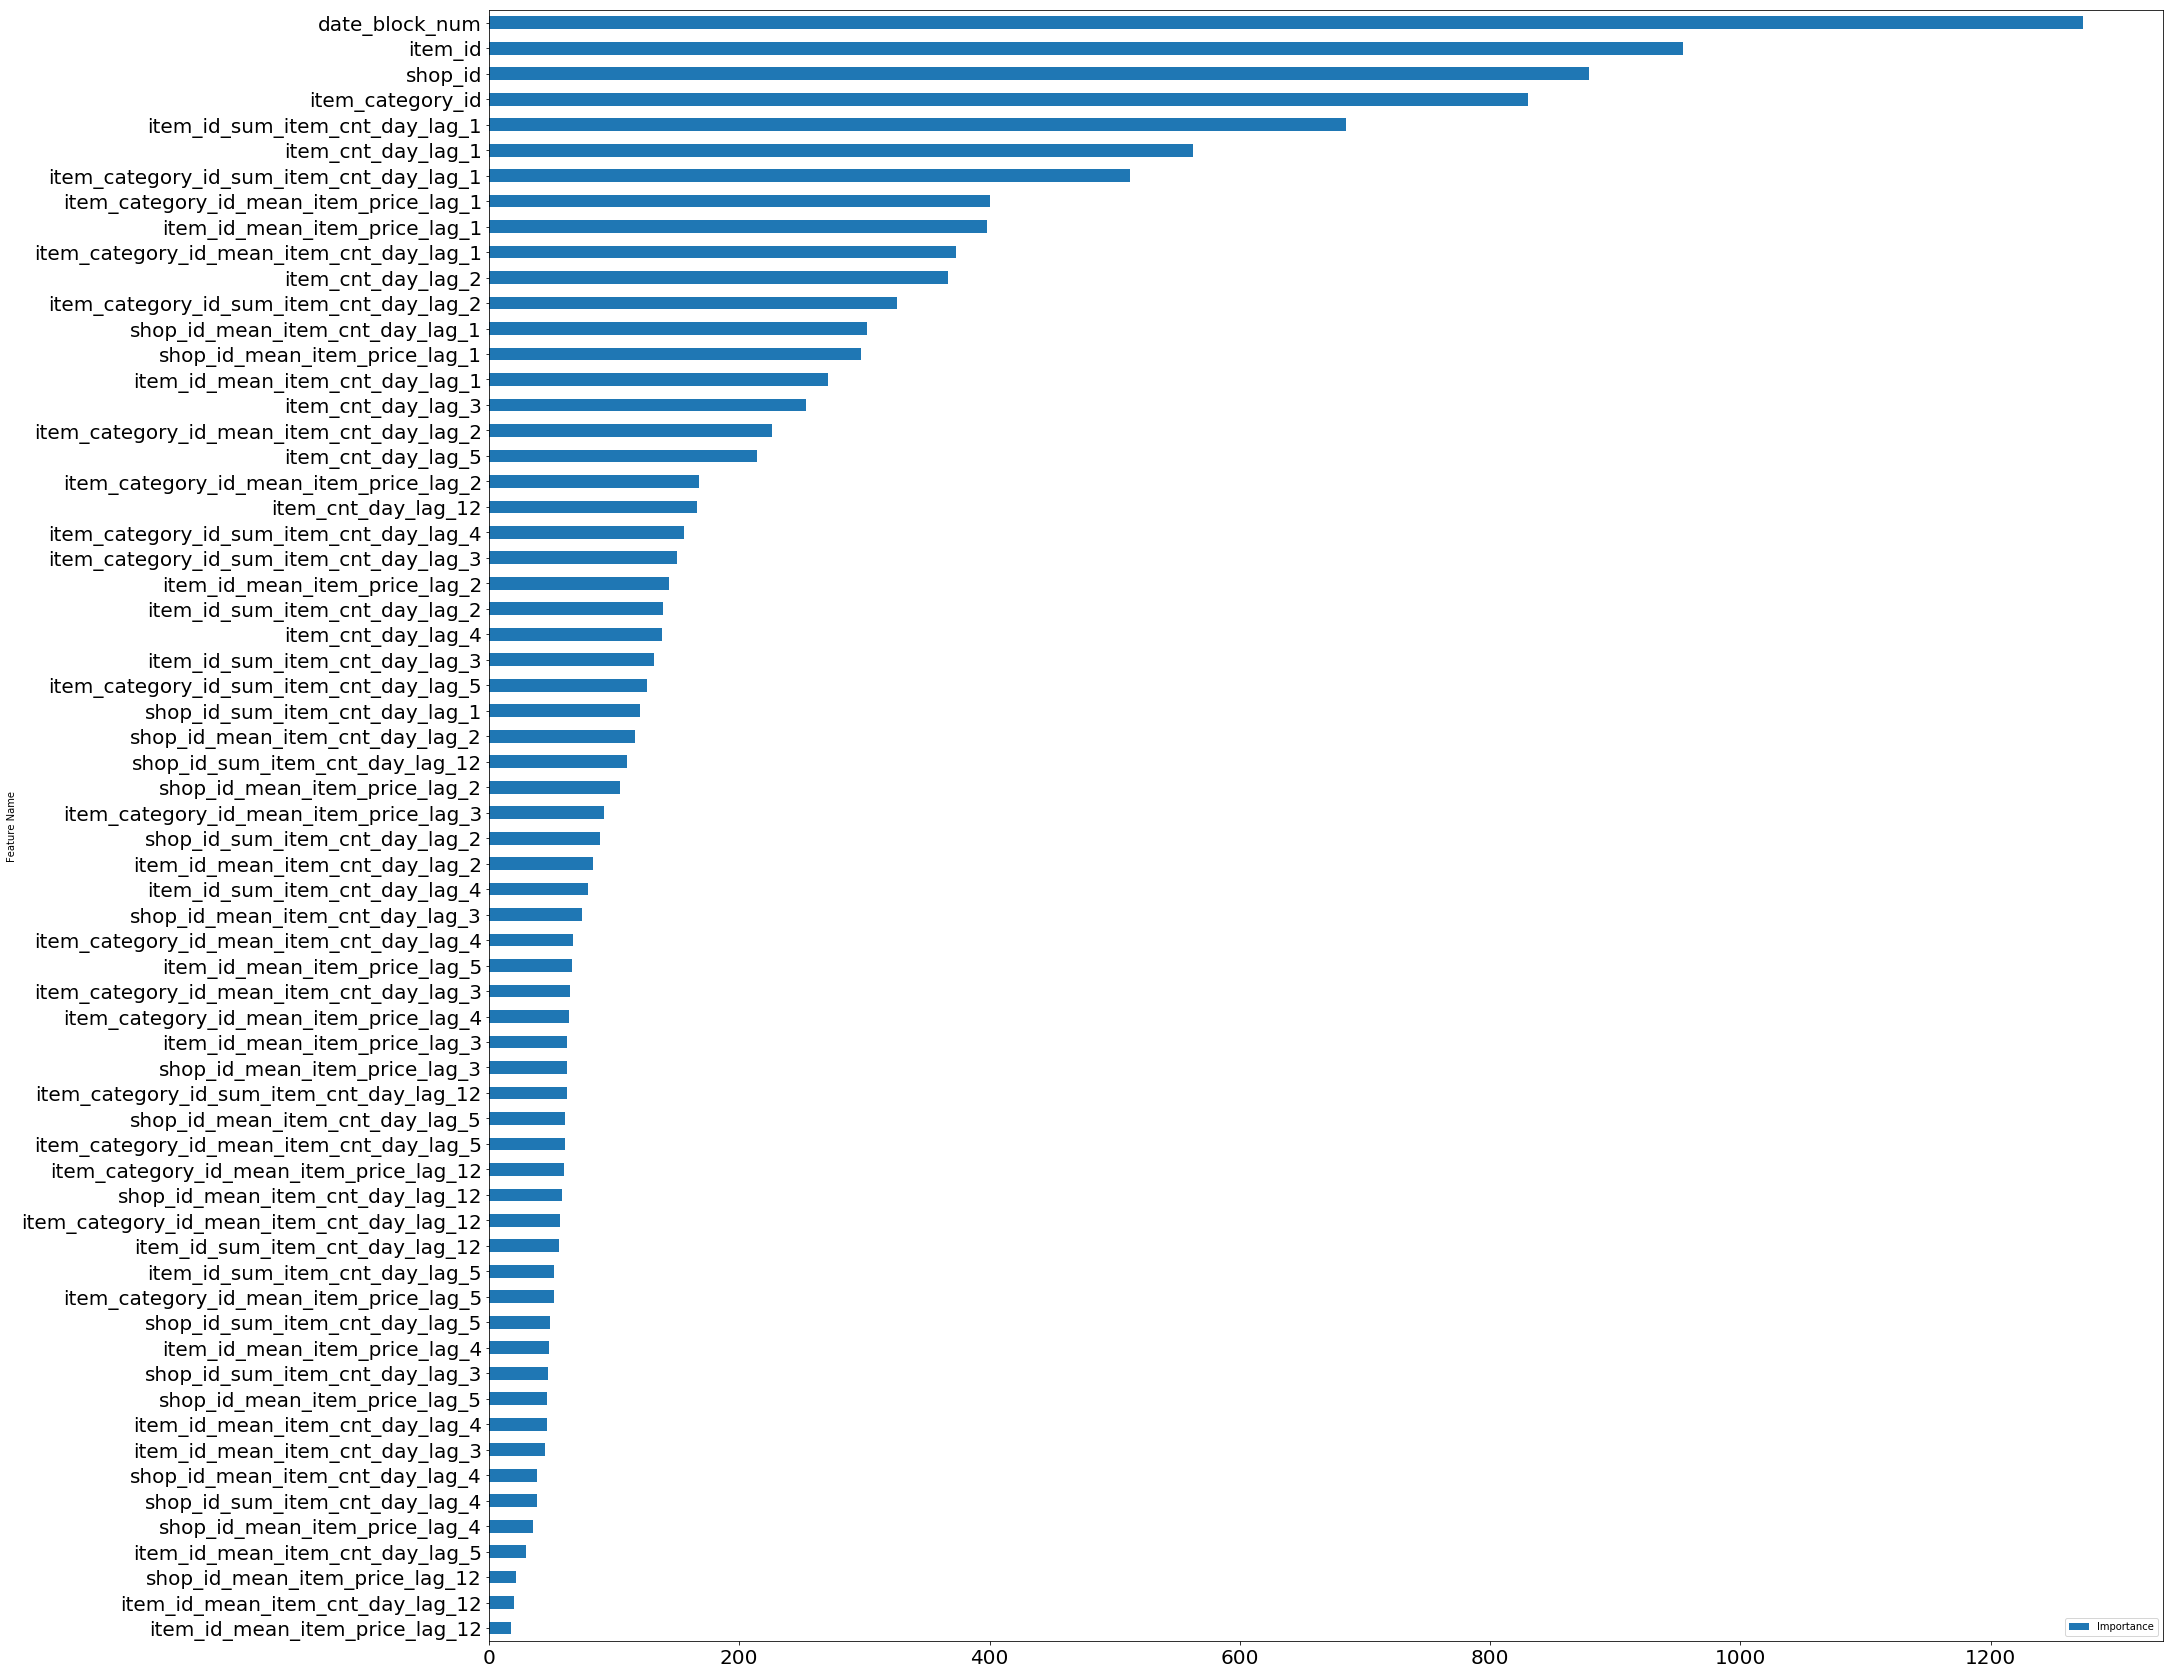

In [20]:
ax = lgb_importances.plot(kind='barh', figsize=(30, 30), fontsize=20)
plt.show()

The date block number is our most important feature, followed by the item id, shop id, item category id then 6 1-month lag variables.

In [21]:
# Feature importances for XGBoost
xgb_importances = pd.DataFrame(xgbmodel.feature_importances_, columns=['Importance'])
xgb_importances['Feature Name'] = feature_names
xgb_importances.sort_values(by=['Importance'], inplace=True)
xgb_importances = xgb_importances[['Feature Name', 'Importance']].set_index('Feature Name')
xgb_importances.head(20)

,Importance
Feature Name,
item_id_mean_item_cnt_day_lag_12,0.002282
item_id_mean_item_cnt_day_lag_5,0.003955
item_id_mean_item_cnt_day_lag_3,0.004208
item_id_mean_item_cnt_day_lag_4,0.004411
shop_id_mean_item_cnt_day_lag_12,0.004715
shop_id_mean_item_cnt_day_lag_4,0.004918
item_id_mean_item_price_lag_12,0.004969
item_category_id_mean_item_cnt_day_lag_5,0.005020
item_id_sum_item_cnt_day_lag_5,0.005172


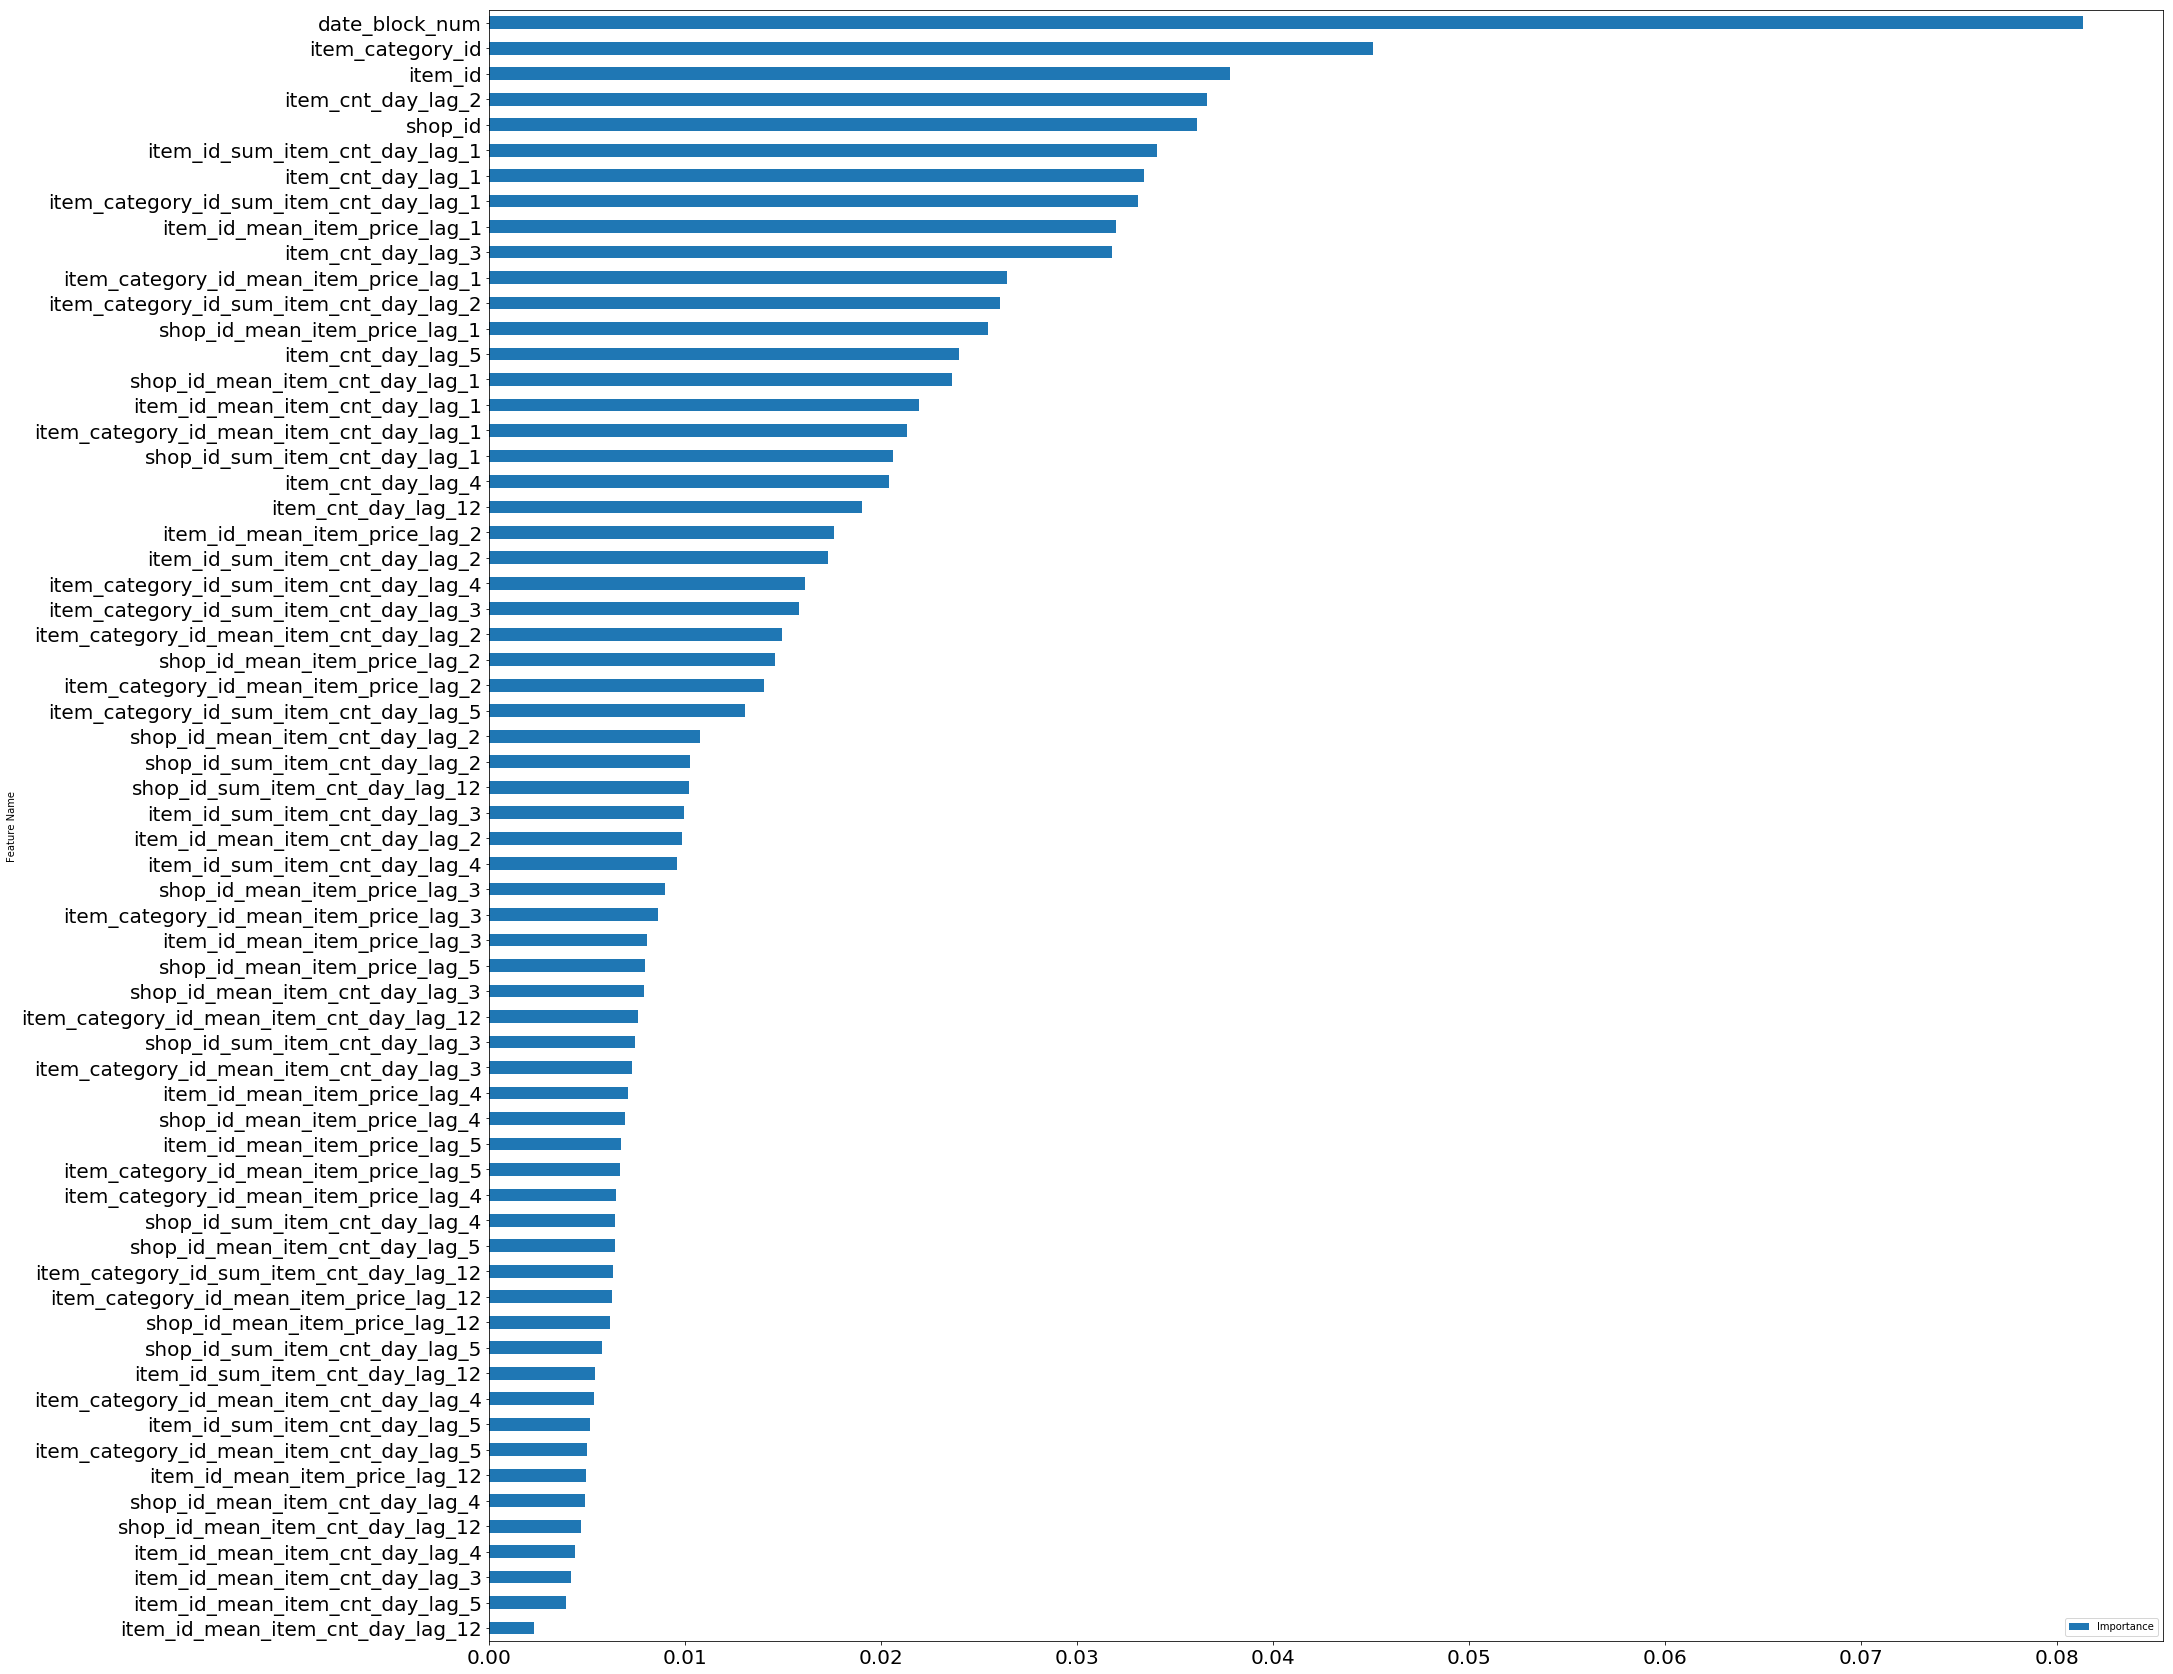

In [22]:
ax = xgb_importances.plot(kind='barh', figsize=(30, 30), fontsize=20)
plt.show()

For XGBoost, the date_block_num was the most important, followed by item_category_id, item_id, item_cnt_day_lag_2 (2 month lag), shop_id then several 1-month lag features.

In [23]:
# Feature importances for Catboost
cb_importances = pd.DataFrame(cbmodel.get_feature_importance(X_train_block.values, y_train_block, thread_count=16), columns=['Importance'])
cb_importances['Feature Name'] = feature_names
cb_importances.sort_values(by=['Importance'], inplace=True)
cb_importances = cb_importances[['Feature Name', 'Importance']].set_index('Feature Name')
cb_importances.tail(20)

,Importance
Feature Name,
item_category_id_mean_item_cnt_day_lag_1,0.0
item_id_mean_item_price_lag_2,0.0
item_category_id_mean_item_cnt_day_lag_12,0.0
item_id_sum_item_cnt_day_lag_2,0.0
shop_id_mean_item_price_lag_2,0.0
shop_id_sum_item_cnt_day_lag_2,0.0
shop_id_mean_item_cnt_day_lag_2,0.0
item_category_id_mean_item_price_lag_2,0.0
item_category_id_sum_item_cnt_day_lag_2,0.0


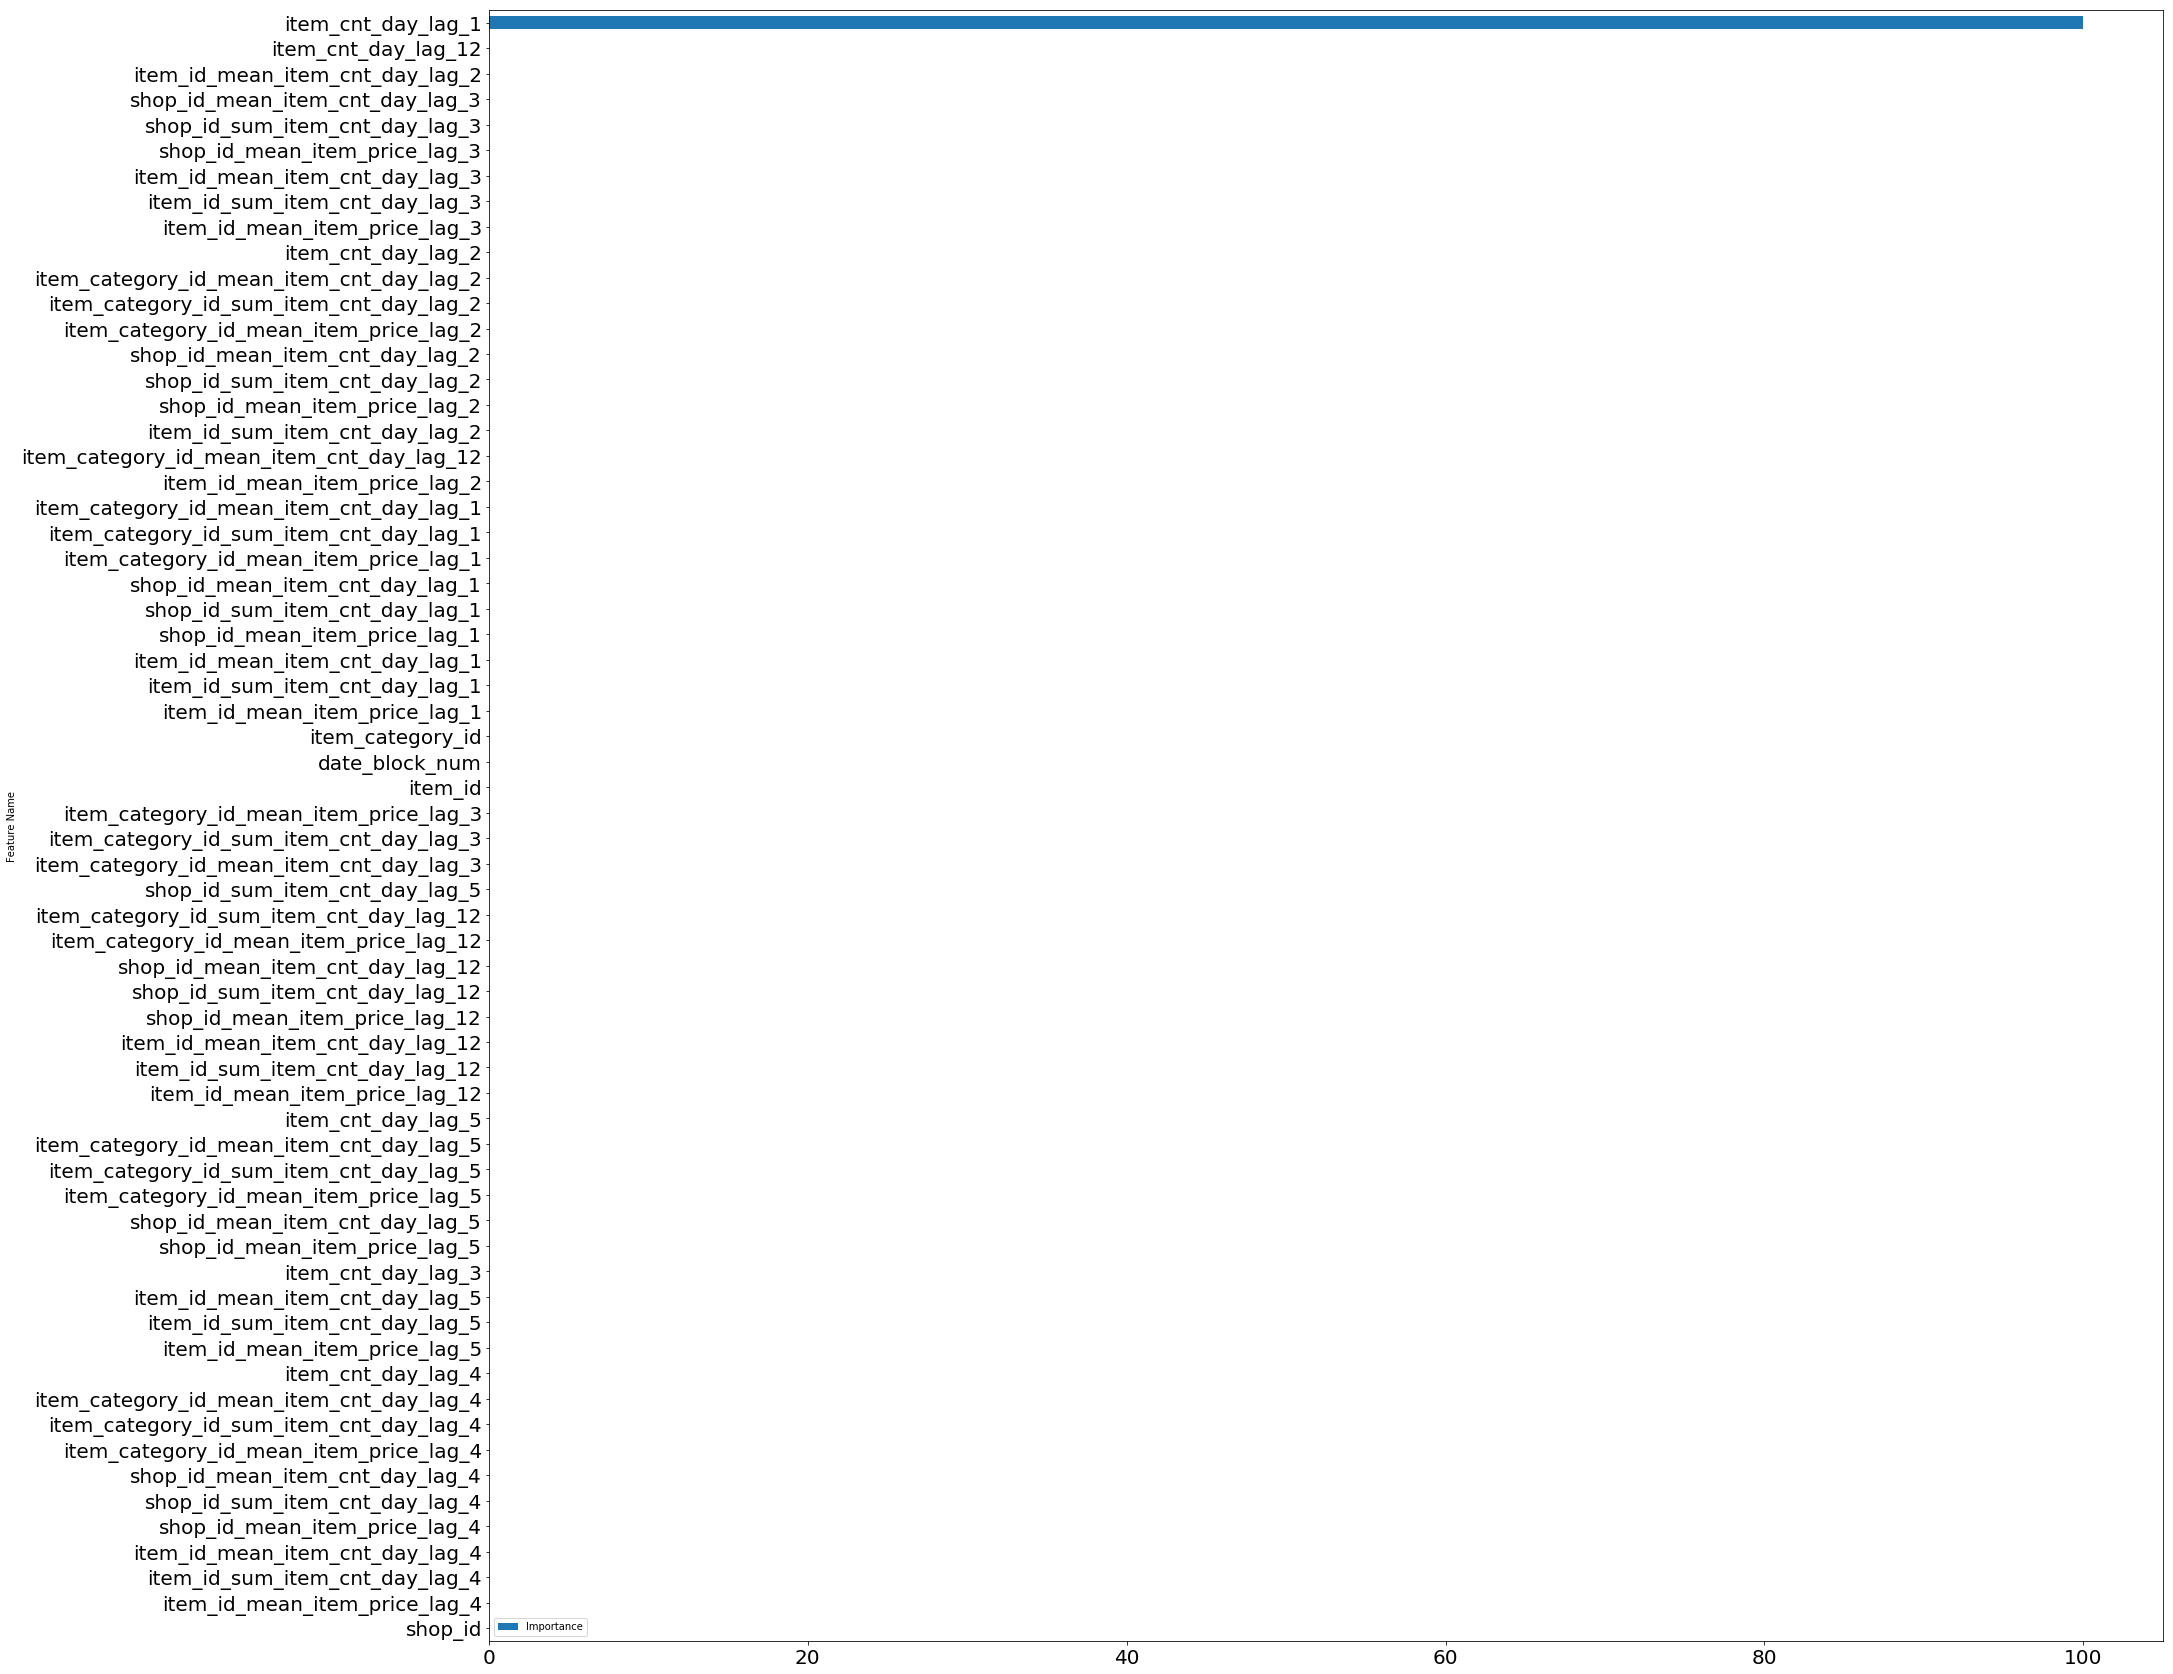

In [24]:
ax = cb_importances.plot(kind='barh', figsize=(30, 30), fontsize=20)
plt.show()

The reason for only one Catboost feature in importance is that the trees have a depth of 1 (selected due to the results of the grid search).

# Ensembling
## Stacking
We will use linear regression to fit the meta-features, using the same parameters as in the model above.

In [25]:
# Set up the model
meta_model = LinearRegression(n_jobs=16)

# Fit the model on months 27 - 33 then predict month 34
start = datetime.now()
meta_lr = meta_model.fit(X_train_level2, y_train_level2)
stop = datetime.now()

print("Ellapsed time = ", stop - start)

Ellapsed time =  0:00:00.041149


Compute the R-squared and RMSE for X_train_level2 and compute the final predictions on X_test_level2

In [26]:
train_preds = meta_lr.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = meta_lr.predict(X_test_level2)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print("Train RMSE for stacking is ", sqrt(mean_squared_error(y_train_level2, train_preds)))

Train R-squared for stacking is 0.420063
Train RMSE for stacking is  1.0606067652767652


## Package up our predictions for submission

In [27]:
print(df_test.shape)
print(X_test_level2.shape)
print(test_preds.shape)

submission = pd.DataFrame(np.reshape(test_preds.clip(0,20), (len(test_preds), 1)), columns=['item_cnt_month'])
submission['ID'] = df_test['ID']
print(list(submission))
submission = submission[['ID', 'item_cnt_month']]

print(submission.shape)
submission.head()

(214200, 3)
(214200, 4)
(214200,)
['item_cnt_month', 'ID']
(214200, 2)


,ID,item_cnt_month
0,0,0.540908
1,1,0.221711
2,2,0.900927
3,3,0.400698
4,4,2.252470


## Write submission to .csv file

In [28]:
submission.to_csv('submission.csv', index=False)

Note - this submission (submission17) scored 0.95281 on the public leaderboard (3/31/2018)

In [29]:
# Save sales to .csv file
sales.to_csv('sales.csv', index=False)

In [31]:
# Save X_train_level2 and X_test_level2
X_train_level2.tofile('x_train_l2.csv', sep=',')
y_train_level2.tofile('y_train_l2.csv', sep=',')
X_test_level2.tofile('x_test_l2.csv', sep=',')

In [32]:
# Save model weights for future use
import pickle

model.save_model('./ml_models/lgbmodel1b.model')
lgbmodel.save_model('./ml_models/lgbmodel1a.model')
pickle.dump(xgbmodel, open('./ml_models/xgbmodel1.model', 'wb'))
cbmodel.save_model('./ml_models/cbmodel1.cbm')